# Water pricing

Water pricing is the most important and the simples instrument to encourage a more efficient use of irrigation in crop production.

In a study publisched in 2015 by the University of Xin Jiang, Hohenheim and the Julius Kuhn-Institut analyze how it's possible to model a Bayesian Network to improve the water usage by variating the water price.

The study was done to improve the water usage in Northwest China, in the Tarim River basin who suffers of extreme water drought's periods.

In [214]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.base import DAG
wPrice="WaterPrice"
dUse="Domestical use"
subsidy="Subsidy"
aGS="Agricultural management"
lessIdoTecniques="Production"
wUseEff="Water efficiency"

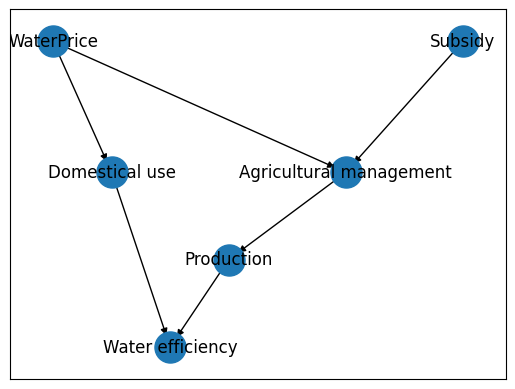

In [215]:

Water_price_model=BayesianNetwork([(wPrice,dUse),(wPrice,aGS),(subsidy,aGS),(aGS,lessIdoTecniques),
                                   (dUse,wUseEff),(lessIdoTecniques,wUseEff)])

nx_graph = nx.DiGraph(Water_price_model.edges())
position={
    wPrice:(3,10),
    subsidy:(10,10),
    dUse:(4,7),
    aGS:(8,7),
    lessIdoTecniques:(6,5),
    wUseEff:(5,3)
}
pos=nx.spring_layout(nx_graph,pos=position,fixed=[wPrice,subsidy],iterations=0)
#pos=nx.nx_pydot.pydot_layout(nx_graph)
nx.draw_networkx_nodes(nx_graph,pos,node_size=500)
nx.draw_networkx_edges(nx_graph,pos,edgelist=Water_price_model.edges(),edge_color="black")
nx.draw_networkx_labels(nx_graph,pos)
plt.show()

In [216]:


Water_price_model=BayesianNetwork([(wPrice,dUse),(wPrice,aGS),(subsidy,aGS),(aGS,lessIdoTecniques),
                                   (dUse,wUseEff),(lessIdoTecniques,wUseEff)])

from pgmpy.factors.discrete import TabularCPD
cpd_wPrice=TabularCPD(
    variable=wPrice,variable_card=2,values=[[0.5],[0.5]]
)
cpd_subsidy=TabularCPD(
    variable=subsidy, variable_card=2,values=[[0.5],[0.5]]
)
cpd_duse=TabularCPD(
    variable=dUse, variable_card=2,values=[[0.2,0.6],[0.8,0.4]],evidence=[wPrice],evidence_card=[2]
)
cpd_aGS=TabularCPD(
    variable=aGS,variable_card=2,values=[[0.98,0.4,1,0.01],[0.02,0.6,0,0.99]],evidence=[wPrice,subsidy],evidence_card=[2,2]
)
cpd_lessIdoTecniques=TabularCPD(
    variable=lessIdoTecniques,variable_card=2,values=[[0.7,0.3],[0.3,0.7]],evidence=[aGS],evidence_card=[2]
)
cpd_waterUseEff=TabularCPD(
    variable=wUseEff,variable_card=3,values=[[0.4,0.05,0.7,0.2],[0.4,0.1,0.25,0.3],[0.2,0.85,0.05,0.5]], evidence=[dUse,lessIdoTecniques],evidence_card=[2,2]
)


Water_price_model.add_cpds(
    cpd_wPrice,cpd_subsidy,cpd_duse,cpd_aGS,cpd_lessIdoTecniques,cpd_waterUseEff
)


In [217]:
Water_price_model.check_model()

True

#### Visualize the CPDs

In [218]:
for cpd in Water_price_model.get_cpds():
    print("CPD of {variable}".format(variable=cpd.variable))
    print(cpd)

CPD of WaterPrice
+---------------+-----+
| WaterPrice(0) | 0.5 |
+---------------+-----+
| WaterPrice(1) | 0.5 |
+---------------+-----+
CPD of Subsidy
+------------+-----+
| Subsidy(0) | 0.5 |
+------------+-----+
| Subsidy(1) | 0.5 |
+------------+-----+
CPD of Domestical use
+-------------------+---------------+---------------+
| WaterPrice        | WaterPrice(0) | WaterPrice(1) |
+-------------------+---------------+---------------+
| Domestical use(0) | 0.2           | 0.6           |
+-------------------+---------------+---------------+
| Domestical use(1) | 0.8           | 0.4           |
+-------------------+---------------+---------------+
CPD of Agricultural management
+----------------------------+-----+---------------+---------------+
| WaterPrice                 | ... | WaterPrice(1) | WaterPrice(1) |
+----------------------------+-----+---------------+---------------+
| Subsidy                    | ... | Subsidy(0)    | Subsidy(1)    |
+----------------------------+-----

### Network domain analisys.

In [219]:
Water_inference = VariableElimination(Water_price_model)

Water domestic use i's not indipendet from less indrofile tecniques beacuse there's a flow of influence between them.

In [220]:
q_1=Water_inference.query([lessIdoTecniques],{dUse:0})
q_2=Water_inference.query([lessIdoTecniques],{dUse:1})
print(q_1==q_2)#must return false

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

False


Domestic usage must be indipendent from Subsidy because there is are two unmarked v-structures between them.

In [221]:
q_3=Water_inference.query([subsidy],{dUse:0})
q_4=Water_inference.query([subsidy],{dUse:1})
print(q_3==q_4)#must return true

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

True


Would have been different if we would have known a less usage of idro tenciques, thanks to the active v-structure.

In [222]:
q_5=Water_inference.query([subsidy],{dUse:0,lessIdoTecniques:0})
q_6=Water_inference.query([subsidy],{dUse:1,lessIdoTecniques:0})
print(q_5==q_6)#must return false

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

False


**Markow blancket** for a given node is made of his parents, his children and his childrens's parents and if this nodes are in the evidence, the given one is independant from all the others.

 If we consider for example the variable ***Less hydropilic tecnologies*** the function markow blanket should return the variables:
 - Agricultural management 
 - Water efficiency
 - Domestical use


In [223]:
Water_price_model.get_markov_blanket(lessIdoTecniques)

['Domestical use', 'Water efficiency', 'Agricultural management']

### Observations

In [229]:
print("P=|(Water efficiency| Water pice=high,subsidy=yes)")
q_1=Water_inference.query([wUseEff],{subsidy:1,wPrice:1})
print(q_1)

P=|(Water efficiency| Water pice=high,subsidy=yes)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+---------------------+-------------------------+
| Water efficiency    |   phi(Water efficiency) |
+=====================+=========================+
| Water efficiency(0) |                  0.2346 |
+---------------------+-------------------------+
| Water efficiency(1) |                  0.2286 |
+---------------------+-------------------------+
| Water efficiency(2) |                  0.5367 |
+---------------------+-------------------------+


### Smapling method

In [303]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
inference=VariableElimination(Water_price_model)
val_piccolo=True
p_subsidy=Water_inference.query([wPrice],{lessIdoTecniques:1}).values[1]
p_subsidy2=Water_inference.query([wPrice],{lessIdoTecniques:1,dUse:0,subsidy:1,wUseEff:1}).values[1]
inference=BayesianModelSampling(Water_price_model)
evidence1=[State(lessIdoTecniques,1)]
evidence2=[State(lessIdoTecniques,1),State(dUse,0),State(wUseEff,1),State(wPrice,1)]
evidence3=[State(lessIdoTecniques,1),State(dUse,0),State(wUseEff,1),State(subsidy,1)]

def prob_LW(samples,var_name):
    return np.sum((samples[str(var_name)]*samples['_weight']))/np.sum(samples['_weight'])

def err_rel(exact_value,approx_value):
    return np.abs((exact_value-approx_value)/exact_value)

def abs_err(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)
evidence3
def sampling(size_sample,evidences,varname,probvarname,choosing=0):
    if choosing==0:
        samplewater_LW=inference.likelihood_weighted_sample(evidence=evidences,size=size_sample,include_latents=False,show_progress=False)
        samplewater_RS=inference.rejection_sample(evidence=evidences,size=size_sample,include_latents=False,show_progress=False)
    elif choosing==1:
        samplewater_LW=inference.likelihood_weighted_sample(evidence=evidences,size=size_sample,include_latents=False,show_progress=False)
        samplewater_RS=inference.rejection_sample(evidence=evidence1,size=size_sample,include_latents=False,show_progress=False)
    elif choosing==2:
        samplewater_LW=inference.likelihood_weighted_sample(evidence=evidence1,size=size_sample,include_latents=False,show_progress=False)
        samplewater_RS=inference.rejection_sample(evidence=evidences,size=size_sample,include_latents=False,show_progress=False)  
    if(val_piccolo==False):
        pwater_LW=1-prob_LW(samplewater_LW,varname)
        pwater_RS=1-np.mean(samplewater_RS[varname],axis=0)
    else:
        pwater_LW=prob_LW(samplewater_LW,varname)
        pwater_RS=np.mean(samplewater_RS[varname],axis=0)
    return np.array([(size_sample,pwater_LW,abs_err(probvarname,pwater_LW,),
                      pwater_RS,abs_err(probvarname,pwater_RS))],
                    dtype=[("size","<i8"),("pwater_LW","<f8"),
                           ("err_LW","<f8"),("pwater_RS","<f8"),("err_RS","<f8")])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [293]:
starting_size_=1 # from 10 sample points
final_size=5   # to 10^5 sample points
experiments=20 # 8 experiments

In [309]:
results=np.array([],dtype=[("size","<i8"),("pwater_LW","<f8"),("err_LW","<f8"),("pwater_RS","<f8"),("err_RS","<f8")])
for size in np.logspace(starting_size_, final_size,num=experiments, dtype='<i8'):
   results=np.append(results,sampling(size,evidence1,wPrice,p_subsidy))

In [295]:
results2=np.array([],dtype=[("size","<i8"),("pwater_LW","<f8"),("err_LW","<f8"),("pwater_RS","<f8"),("err_RS","<f8")])
for size in np.logspace(starting_size_, final_size,num=experiments, dtype='<i8'):
   results2=np.append(results2,sampling(size,evidence3,wPrice,p_subsidy2))

In [304]:
results2=np.array([],dtype=[("size","<i8"),("pwater_LW","<f8"),("err_LW","<f8"),("pwater_RS","<f8"),("err_RS","<f8")])
for size in np.logspace(starting_size_, final_size,num=experiments, dtype='<i8'):
   results2=np.append(results2,sampling(size,evidence3,wPrice,p_subsidy2,2))

In [310]:
results2=np.array([],dtype=[("size","<i8"),("pwater_LW","<f8"),("err_LW","<f8"),("pwater_RS","<f8"),("err_RS","<f8")])
for size in np.logspace(starting_size_, final_size,num=experiments, dtype='<i8'):
   results2=np.append(results2,sampling(size,evidence3,wPrice,p_subsidy2,1))

[]

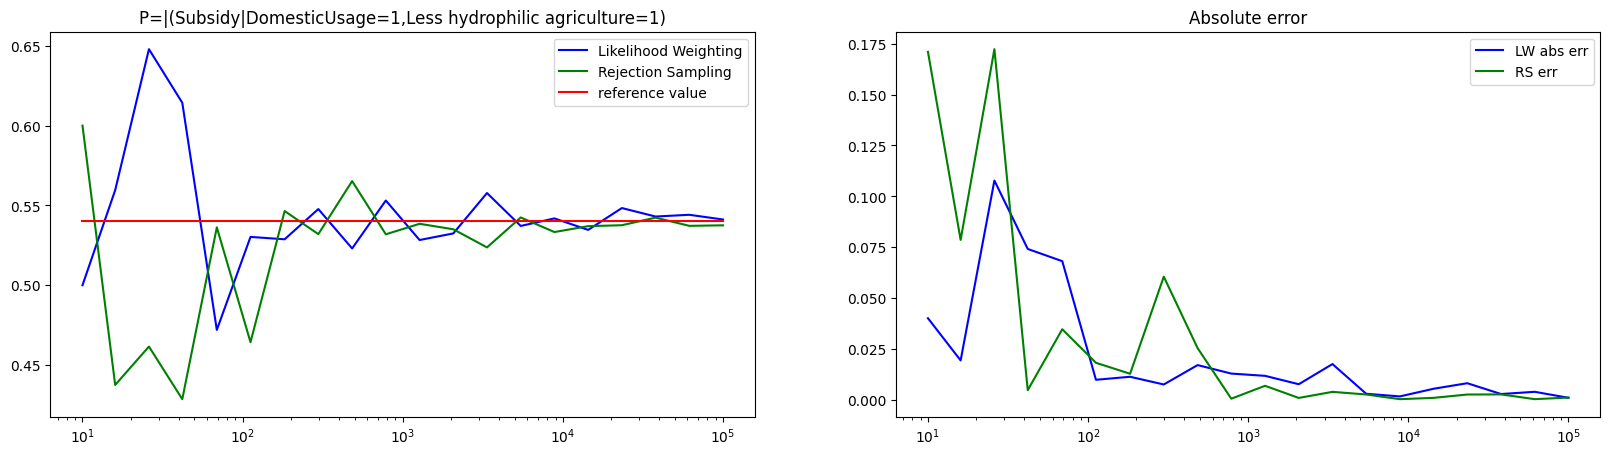

In [311]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title("P=|(Subsidy|DomesticUsage=1,Less hydrophilic agriculture=1)")
LWCplot, = plt.semilogx(results["size"],results["pwater_LW"],'blue',label="Likelihood Weighting")
RSCplot, = plt.semilogx(results['size'],results['pwater_RS'],'green',label="Rejection Sampling")
VECplot, = plt.semilogx(results['size'],p_subsidy*np.ones(results.size),'r',label="reference value")
plt.legend(handles=[LWCplot,RSCplot,VECplot])
plt.subplot(122)
plt.title("Absolute error")
ELWCplot, = plt.semilogx(results['size'],results['err_LW'],'b',label="LW abs err")
ERSCplot, = plt.semilogx(results2['size'],results2['err_LW'],'g',label="RS err")
plt.legend(handles=[ELWCplot,ERSCplot])

plt.plot()